In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [34]:
train_df = pd.read_csv('dataset/train_dataset.csv')
val_df = pd.read_csv('dataset/val_dataset.csv')
test_df = pd.read_csv('dataset/test_dataset.csv')

In [35]:
# 데이터프레임을 시퀀스로 변환
def create_sequences(df, input_columns):
    """
    Group_ID를 기준으로 데이터를 묶어 시퀀스를 생성합니다.

    Parameters:
    - df (pd.DataFrame): 입력 데이터프레임 (Group_ID 포함)
    - input_columns (list): 모델 입력으로 사용할 칼럼 리스트

    Returns:
    - X (list of np.array): 각 그룹의 시퀀스 데이터
    - y (list): 각 시퀀스의 타겟 라벨
    
    """
    # X : 입력, y : 라벨
    X, y = [], []

    # Group_ID별로 데이터 묶기
    for group_id, group in df.groupby('Group_ID'):
        # 그룹의 입력 데이터 추출
        features = group[input_columns].values

        # 그룹의 타겟값 (예: 마지막 Hazard 값 사용)
        label = group['Hazard'].iloc[-1]  # 그룹의 마지막 라벨을 타겟으로 사용

        X.append(features)
        y.append(label)

    return np.array(X, dtype=object), np.array(y)

In [36]:
# 사용할 입력 칼럼을 지정
input_columns = [
    'LONGITUDE', 'LATITUDE', 
    'HEADING', 'SPEED', 'BRAKE_STATUS', 
    'ACC_SEC', 'CURRENT_LANE'
]

# 시퀀스 생성
X_train, y_train = create_sequences(train_df, input_columns)
X_val, y_val = create_sequences(val_df, input_columns)
X_test, y_test = create_sequences(test_df, input_columns)

X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

print(f"Train Input Shape: {X_train.shape}")
print(f"Train Target Shape: {y_train.shape}")
print('=================')
print(f"Validation Input Shape: {X_val.shape}")
print(f"Validation Target Shape: {y_val.shape}")
print('=================')
print(f"Test Input Shape: {X_test.shape}")
print(f"Test Target Shape: {y_test.shape}")

Train Input Shape: (31674, 10, 7)
Train Target Shape: (31674,)
Validation Input Shape: (6787, 10, 7)
Validation Target Shape: (6787,)
Test Input Shape: (6788, 10, 7)
Test Target Shape: (6788,)


In [37]:
# 스케일러 생성
scaler = StandardScaler()

# 정규화는 훈련 데이터에서만 학습
X_train_flat = np.concatenate([x for x in X_train])  # 3D 데이터를 2D로 변환
scaler.fit(X_train_flat)  # 훈련 데이터로 스케일러 학습

# 훈련 데이터 정규화
X_train_scaled = []
for x in X_train:
    X_train_scaled.append(scaler.transform(x))
X_train_scaled = np.array(X_train_scaled, dtype=np.float32)

# 검증 데이터 정규화
X_val_scaled = []
for x in X_val:
    X_val_scaled.append(scaler.transform(x))
X_val_scaled = np.array(X_val_scaled, dtype=np.float32)

# 테스트 데이터 정규화
X_test_scaled = []
for x in X_test:
    X_test_scaled.append(scaler.transform(x))
X_test_scaled = np.array(X_test_scaled, dtype=np.float32)

# 정규화된 데이터 출력
print(f"Train Input Shape after Scaling: {X_train_scaled.shape}")
print(f"Validation Input Shape after Scaling: {X_val_scaled.shape}")
print(f"Test Input Shape after Scaling: {X_test_scaled.shape}")

Train Input Shape after Scaling: (31674, 10, 7)
Validation Input Shape after Scaling: (6787, 10, 7)
Test Input Shape after Scaling: (6788, 10, 7)


In [38]:
# 평가지표 출력 함수
def print_score(y_pred):
    accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    precision = precision_score(y_test, (y_pred > 0.5).astype(int))
    recall = recall_score(y_test, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_test, (y_pred > 0.5).astype(int))

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

In [39]:
# 혼동행렬 출력 함수
def print_cm(y_pred, version):
    # 혼동행렬 계산
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

    # 혼동행렬을 백분율로 변환
    cm_percentage = cm.astype('float') / cm.sum() * 100  # 전체 데이터에 대한 비율 계산

    # ConfusionMatrixDisplay에 백분율 적용
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format=".2f")  # 백분율 출력 형식 설정
    plt.title(f"Model {version} Confusion Matrix (Percentage)")
    plt.show()

In [40]:
# MLSTM-CNN 모델 생성 함수
def mlstm_cnn_model(input_shape, num_classes):
    """
    MLSTM-CNN 모델 생성

    Parameters:
    - input_shape: 입력 데이터의 형태 (time_steps, features)
    - num_classes: 출력 클래스 수

    Returns:
    - model: 생성된 MLSTM-CNN 모델
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Multi-Layer LSTM
    lstm_out = layers.LSTM(64, return_sequences=True)(inputs)
    lstm_out = layers.LSTM(32, return_sequences=True)(lstm_out)

    # CNN Layer
    conv_out = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(lstm_out)
    conv_out = layers.MaxPooling1D(pool_size=2)(conv_out)

    # Flatten Layer
    flatten = layers.Flatten()(conv_out)

    # Fully Connected Layer
    dense = layers.Dense(128, activation='relu')(flatten)
    outputs = layers.Dense(num_classes, activation='sigmoid')(dense)

    # Model Definition
    model = models.Model(inputs, outputs)
    return model

In [41]:
input_shape=(10, len(input_columns))
num_classes = 1        # 이진 분류

model = mlstm_cnn_model(input_shape, num_classes)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10, 7)]           0         
                                                                 
 lstm_10 (LSTM)              (None, 10, 64)            18432     
                                                                 
 lstm_11 (LSTM)              (None, 10, 32)            12416     
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 64)             6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                           

c:\Users\PEJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [42]:
# 모델 학습
history = model.fit(
    X_train_scaled, y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/100
990/990 [==============================] - 9s 7ms/step - loss: 0.6084 - accuracy: 0.6667 - val_loss: 0.5990 - val_accuracy: 0.6680
Epoch 2/100
990/990 [==============================] - 7s 7ms/step - loss: 0.5877 - accuracy: 0.6739 - val_loss: 0.5926 - val_accuracy: 0.6703
Epoch 3/100
990/990 [==============================] - 7s 7ms/step - loss: 0.5838 - accuracy: 0.6759 - val_loss: 0.5905 - val_accuracy: 0.6720
Epoch 4/100
990/990 [==============================] - 7s 7ms/step - loss: 0.5811 - accuracy: 0.6789 - val_loss: 0.5884 - val_accuracy: 0.6708
Epoch 5/100
990/990 [==============================] - 7s 7ms/step - loss: 0.5779 - accuracy: 0.6805 - val_loss: 0.5841 - val_accuracy: 0.6772
Epoch 6/100
990/990 [==============================] - 7s 7ms/step - loss: 0.5740 - accuracy: 0.6848 - val_loss: 0.5792 - val_accuracy: 0.6769
Epoch 7/100
990/990 [==============================] - 7s 7ms/step - loss: 0.5693 - accuracy: 0.6891 - val_loss: 0.5759 - val_accuracy: 0.6838

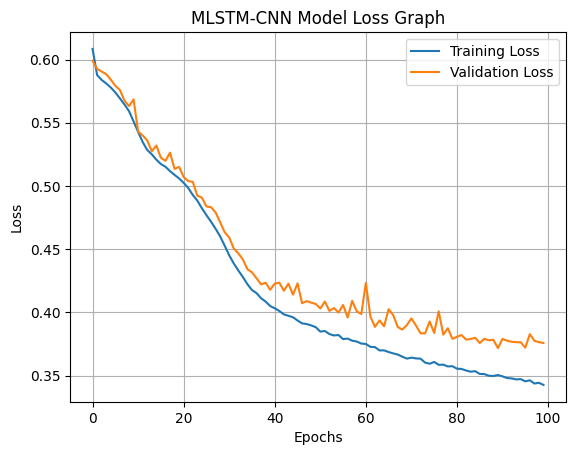

In [43]:
# History에서 loss와 val_loss 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 그래프 그리기
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLSTM-CNN Model Loss Graph')
plt.legend()
plt.grid()
plt.show()

213/213 [==============================] - 1s 3ms/step
Accuracy: 0.832
Precision: 0.754
Recall: 0.744
F1-Score: 0.749


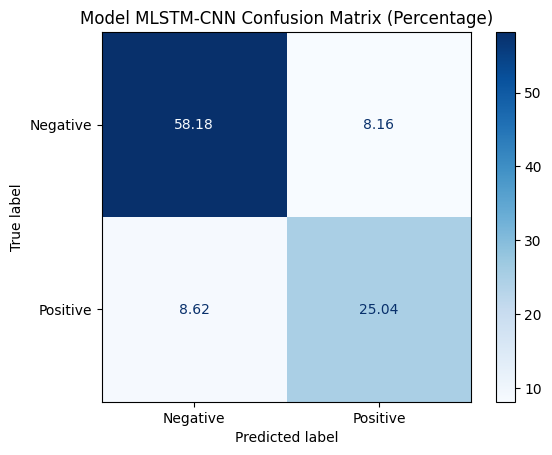

In [44]:
# 테스트 데이터 예측
y_pred_v1 = model.predict(X_test_scaled)
print_score(y_pred=y_pred_v1)
print_cm(y_pred_v1, 'MLSTM-CNN')

In [11]:
# LSTM 모델 정의 : 단일 LSTM 레이어
model_v1 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(None, len(input_columns))),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # 이진 분류
])

model_v1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# LSTM 모델 정의 : 2개의 LSTM 레이어
model_v2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, len(input_columns))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),  # 두 번째 LSTM 레이어
    Dropout(0.2),
    Dense(1, activation='sigmoid') # 이진 분류
])

model_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# 모델 학습
history_v1 = model_v1.fit(
    X_train_scaled, y_train, 
    batch_size=32, 
    epochs=30, 
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/30
990/990 [==============================] - 5s 4ms/step - loss: 0.5994 - accuracy: 0.6696 - val_loss: 0.5938 - val_accuracy: 0.6705
Epoch 2/30
990/990 [==============================] - 4s 4ms/step - loss: 0.5826 - accuracy: 0.6794 - val_loss: 0.5851 - val_accuracy: 0.6756
Epoch 3/30
990/990 [==============================] - 4s 4ms/step - loss: 0.5741 - accuracy: 0.6867 - val_loss: 0.5730 - val_accuracy: 0.6828
Epoch 4/30
990/990 [==============================] - 4s 4ms/step - loss: 0.5600 - accuracy: 0.6957 - val_loss: 0.5513 - val_accuracy: 0.7119
Epoch 5/30
990/990 [==============================] - 4s 4ms/step - loss: 0.5439 - accuracy: 0.7136 - val_loss: 0.5333 - val_accuracy: 0.7229
Epoch 6/30
990/990 [==============================] - 4s 4ms/step - loss: 0.5321 - accuracy: 0.7249 - val_loss: 0.5771 - val_accuracy: 0.7102
Epoch 7/30
990/990 [==============================] - 4s 4ms/step - loss: 0.5228 - accuracy: 0.7321 - val_loss: 0.5466 - val_accuracy: 0.7086
Epoch 

In [14]:
# 모델 학습
history_v2 = model_v2.fit(
    X_train_scaled, y_train, 
    batch_size=32, 
    epochs=30, 
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/30
990/990 [==============================] - 7s 6ms/step - loss: 0.5985 - accuracy: 0.6685 - val_loss: 0.5964 - val_accuracy: 0.6617
Epoch 2/30
990/990 [==============================] - 6s 6ms/step - loss: 0.5847 - accuracy: 0.6756 - val_loss: 0.5897 - val_accuracy: 0.6729
Epoch 3/30
990/990 [==============================] - 6s 6ms/step - loss: 0.5757 - accuracy: 0.6840 - val_loss: 0.5792 - val_accuracy: 0.6784
Epoch 4/30
990/990 [==============================] - 6s 6ms/step - loss: 0.5632 - accuracy: 0.6951 - val_loss: 0.5723 - val_accuracy: 0.6882
Epoch 5/30
990/990 [==============================] - 6s 6ms/step - loss: 0.5483 - accuracy: 0.7100 - val_loss: 0.5388 - val_accuracy: 0.7231
Epoch 6/30
990/990 [==============================] - 6s 6ms/step - loss: 0.5284 - accuracy: 0.7266 - val_loss: 0.5275 - val_accuracy: 0.7193
Epoch 7/30
990/990 [==============================] - 6s 6ms/step - loss: 0.5114 - accuracy: 0.7345 - val_loss: 0.5160 - val_accuracy: 0.7423
Epoch 

213/213 [==============================] - 0s 1ms/step
Accuracy: 0.831
Precision: 0.746
Recall: 0.753
F1-Score: 0.749


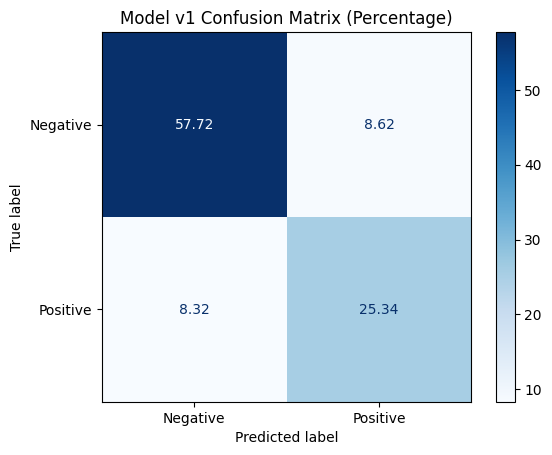

In [15]:
# 테스트 데이터 예측
y_pred_v1 = model_v1.predict(X_test_scaled)
print_score(y_pred=y_pred_v1)
print_cm(y_pred_v1, 'v1')

213/213 [==============================] - 1s 2ms/step
Accuracy: 0.836
Precision: 0.760
Recall: 0.748
F1-Score: 0.754


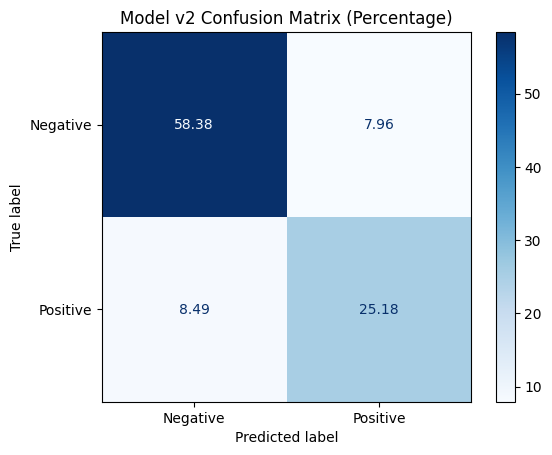

In [16]:
# 테스트 데이터 예측
y_pred_v2 = model_v2.predict(X_test_scaled)
print_score(y_pred=y_pred_v2)
print_cm(y_pred_v2, 'v2')